<h1>Loading Libraries<h1>

In [20]:
import os
import torch
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)
import seaborn as sns
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

<h1>Splitting Dataset<h1>

In [21]:
import os
import shutil
import random


SOURCE_DIR = r"C:\Users\aljaf\Downloads\chestxray_20k"
TARGET_DIR = r"C:\Users\aljaf\Downloads\chestxray_20k"

splits = {
    "train": 0.7,
    "val": 0.15,
    "test": 0.15
}

random.seed(42)

classes = ["normal", "abnormal"]

for split in splits:
    for cls in classes:
        os.makedirs(os.path.join(TARGET_DIR, split, cls), exist_ok=True)

for cls in classes:
    images = os.listdir(os.path.join(SOURCE_DIR, cls))
    random.shuffle(images)

    n_total = len(images)
    n_train = int(n_total * splits["train"])
    n_val = int(n_total * splits["val"])

    train_imgs = images[:n_train]
    val_imgs = images[n_train:n_train + n_val]
    test_imgs = images[n_train + n_val:]

    for img in train_imgs:
        shutil.copy(
            os.path.join(SOURCE_DIR, cls, img),
            os.path.join(TARGET_DIR, "train", cls, img)
        )

    for img in val_imgs:
        shutil.copy(
            os.path.join(SOURCE_DIR, cls, img),
            os.path.join(TARGET_DIR, "val", cls, img)
        )

    for img in test_imgs:
        shutil.copy(
            os.path.join(SOURCE_DIR, cls, img),
            os.path.join(TARGET_DIR, "test", cls, img)
        )

print("Dataset split completed!")


Dataset split completed!


In [22]:
for split in ["train", "val", "test"]:
    for cls in ["normal", "abnormal"]:
        path = os.path.join(TARGET_DIR, split, cls)
        print(split, cls, ":", len(os.listdir(path)))


train normal : 7000
train abnormal : 7000
val normal : 1500
val abnormal : 1500
test normal : 1500
test abnormal : 1500


## Dataset Preparation

The NIH Chest X-ray dataset was filtered to include 20,000 images with balanced classes.
Images were organized into training (70%), validation (15%), and testing (15%) subsets.
Each subset maintains equal distribution between normal and abnormal cases to avoid class imbalance.


In [23]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15
LR = 1e-3

train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

val_test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


train_dataset = datasets.ImageFolder(
    root=f"{TARGET_DIR}/train",
    transform=train_transform
)

val_dataset = datasets.ImageFolder(
    root=f"{TARGET_DIR}/val",
    transform=val_test_transform
)

test_dataset = datasets.ImageFolder(
    root=f"{TARGET_DIR}/test",
    transform=val_test_transform
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Classes:", train_dataset.classes)


Classes: ['abnormal', 'normal']


In [5]:
class ChestXrayCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),   # 224 → 112

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),   # 112 → 56

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),   # 56 → 28
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [6]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ChestXrayCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

print("Using device:", device)


Using device: cuda


In [6]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    num_batches = len(loader)

    for batch_idx, (images, labels) in enumerate(loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

        
        if batch_idx % 50 == 0:
            print(
                f"Batch {batch_idx}/{num_batches} "
                f"- Loss: {loss.item():.4f}"
            )

    epoch_loss = running_loss / num_batches
    epoch_acc = correct / total

    return epoch_loss, epoch_acc




def evaluate(model, loader, device):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

    return correct / total



In [32]:
for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader)
    val_acc = evaluate(model, val_loader)

    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Train Loss: {train_loss:.4f} | "
          f"Train Acc: {train_acc:.4f} | "
          f"Val Acc: {val_acc:.4f}")


Batch 0/438 - Loss: 0.7927
Batch 50/438 - Loss: 0.6894
Batch 100/438 - Loss: 0.7192
Batch 150/438 - Loss: 0.6771
Batch 200/438 - Loss: 0.6732
Batch 250/438 - Loss: 0.6933
Batch 300/438 - Loss: 0.6816
Batch 350/438 - Loss: 0.6588
Batch 400/438 - Loss: 0.6935
Epoch [1/15] Train Loss: 1.0069 | Train Acc: 0.5355 | Val Acc: 0.6287
Batch 0/438 - Loss: 0.6578
Batch 50/438 - Loss: 0.6938
Batch 100/438 - Loss: 0.7459
Batch 150/438 - Loss: 0.7228
Batch 200/438 - Loss: 0.7038
Batch 250/438 - Loss: 0.6938
Batch 300/438 - Loss: 0.6500
Batch 350/438 - Loss: 0.6734
Batch 400/438 - Loss: 0.7801
Epoch [2/15] Train Loss: 0.6847 | Train Acc: 0.5357 | Val Acc: 0.5893
Batch 0/438 - Loss: 0.6837
Batch 50/438 - Loss: 0.7496
Batch 100/438 - Loss: 0.6580
Batch 150/438 - Loss: 0.6631
Batch 200/438 - Loss: 0.6723
Batch 250/438 - Loss: 0.7048
Batch 300/438 - Loss: 0.6678
Batch 350/438 - Loss: 0.7116
Batch 400/438 - Loss: 0.6682
Epoch [3/15] Train Loss: 0.6832 | Train Acc: 0.5504 | Val Acc: 0.6317
Batch 0/438 - Lo

<h1>ResNet18</h1>

In [9]:
from torchvision.models import resnet18, ResNet18_Weights

model = resnet18(weights=ResNet18_Weights.DEFAULT)


In [3]:
from torchvision.models import resnet18, ResNet18_Weights
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = resnet18(weights=ResNet18_Weights.DEFAULT)

# Freeze backbone
for param in model.parameters():
    param.requires_grad = False


model.fc = nn.Linear(model.fc.in_features, 2)

model = model.to(device)


In [4]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    model.fc.parameters(),
    lr=1e-3
)


In [45]:
EPOCHS = 15

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(
        model, train_loader, optimizer, criterion,device
    )

    val_acc = evaluate(model, val_loader)

    print(
        f"Epoch [{epoch+1}/{EPOCHS}] | "
        f"Train Loss: {train_loss:.4f} | "
        f"Train Acc: {train_acc:.4f} | "
        f"Val Acc: {val_acc:.4f}"
    )


Batch 0/438 - Loss: 0.8351
Batch 50/438 - Loss: 0.6692
Batch 100/438 - Loss: 0.5916
Batch 150/438 - Loss: 0.7272
Batch 200/438 - Loss: 0.5952
Batch 250/438 - Loss: 0.7167
Batch 300/438 - Loss: 0.6126
Batch 350/438 - Loss: 0.7242
Batch 400/438 - Loss: 0.5980
Epoch [1/15] | Train Loss: 0.6636 | Train Acc: 0.6104 | Val Acc: 0.6317
Batch 0/438 - Loss: 0.5649
Batch 50/438 - Loss: 0.7809
Batch 100/438 - Loss: 0.5878
Batch 150/438 - Loss: 0.6327
Batch 200/438 - Loss: 0.5447
Batch 250/438 - Loss: 0.6659
Batch 300/438 - Loss: 0.7925
Batch 350/438 - Loss: 0.5626
Batch 400/438 - Loss: 0.7451
Epoch [2/15] | Train Loss: 0.6398 | Train Acc: 0.6377 | Val Acc: 0.6560
Batch 0/438 - Loss: 0.6460
Batch 50/438 - Loss: 0.6487
Batch 100/438 - Loss: 0.5584
Batch 150/438 - Loss: 0.5908
Batch 200/438 - Loss: 0.6752
Batch 250/438 - Loss: 0.6153
Batch 300/438 - Loss: 0.5954
Batch 350/438 - Loss: 0.8261
Batch 400/438 - Loss: 0.6049
Epoch [3/15] | Train Loss: 0.6401 | Train Acc: 0.6472 | Val Acc: 0.6387
Batch 0/43

In [5]:
for param in model.parameters():
    param.requires_grad = False


In [6]:
# Unfreeze last convolutional block
for param in model.layer4.parameters():
    param.requires_grad = True

# Unfreeze classifier
for param in model.fc.parameters():
    param.requires_grad = True


In [7]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4
)


In [8]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_acc = 0
        self.counter = 0
        self.should_stop = False

    def step(self, val_acc):
        if val_acc > self.best_acc + self.min_delta:
            self.best_acc = val_acc
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True


In [9]:
early_stopping = EarlyStopping(patience=3)


In [10]:
best_val_acc = 0.0
BEST_MODEL_PATH = "best_resnet18.pth"


In [65]:
for epoch in range(EPOCHS):

    train_loss, train_acc = train_one_epoch(
        model,
        train_loader,
        optimizer,
        criterion,
        device
    )

    val_acc = evaluate(model, val_loader,device)

    print(
        f"Epoch [{epoch+1}/{EPOCHS}] | "
        f"Train Loss: {train_loss:.4f} | "
        f"Train Acc: {train_acc:.4f} | "
        f"Val Acc: {val_acc:.4f}"
    )

    # ✅ Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print(f"💾 Best model saved (Val Acc = {val_acc:.4f})")

    early_stopping.step(val_acc)
    if early_stopping.should_stop:
        print("⛔ Early stopping triggered")
        break


Batch 0/438 - Loss: 0.0176
Batch 50/438 - Loss: 0.0106
Batch 100/438 - Loss: 0.1085
Batch 150/438 - Loss: 0.1515
Batch 200/438 - Loss: 0.0658
Batch 250/438 - Loss: 0.0215
Batch 300/438 - Loss: 0.0269
Batch 350/438 - Loss: 0.0252
Batch 400/438 - Loss: 0.0532
Epoch [1/15] | Train Loss: 0.0440 | Train Acc: 0.9834 | Val Acc: 0.6430
💾 Best model saved (Val Acc = 0.6430)
Batch 0/438 - Loss: 0.0585
Batch 50/438 - Loss: 0.1184
Batch 100/438 - Loss: 0.1343
Batch 150/438 - Loss: 0.0013
Batch 200/438 - Loss: 0.3310
Batch 250/438 - Loss: 0.0622
Batch 300/438 - Loss: 0.0589
Batch 350/438 - Loss: 0.0189
Batch 400/438 - Loss: 0.0188
Epoch [2/15] | Train Loss: 0.0479 | Train Acc: 0.9829 | Val Acc: 0.6577
💾 Best model saved (Val Acc = 0.6577)
Batch 0/438 - Loss: 0.0041
Batch 50/438 - Loss: 0.0251
Batch 100/438 - Loss: 0.1233
Batch 150/438 - Loss: 0.0522
Batch 200/438 - Loss: 0.0677
Batch 250/438 - Loss: 0.0214
Batch 300/438 - Loss: 0.0008
Batch 350/438 - Loss: 0.0840
Batch 400/438 - Loss: 0.0118
Epoch 

In [11]:
model.load_state_dict(torch.load(BEST_MODEL_PATH, weights_only=True))


<All keys matched successfully>

In [14]:
from torchvision import models
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

BEST_MODEL_PATH = "best_resnet18.pth"
model.load_state_dict(torch.load(BEST_MODEL_PATH, weights_only=True))
model.eval()

print("✅ Best model loaded and ready")


✅ Best model loaded and ready


In [11]:

test_dataset = test_loader.dataset

print("Classes:", test_dataset.classes)


Classes: ['abnormal', 'normal']


In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.eval()

y_true = []
y_pred = []
y_prob = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # probability of class 1 (normal)
        preds = outputs.argmax(dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_prob.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)


In [43]:
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_prob)

print("📊 Test Results")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")


📊 Test Results
Accuracy : 0.6613
Precision: 0.6660
Recall   : 0.6473
F1-score : 0.6565
AUC      : 0.7109


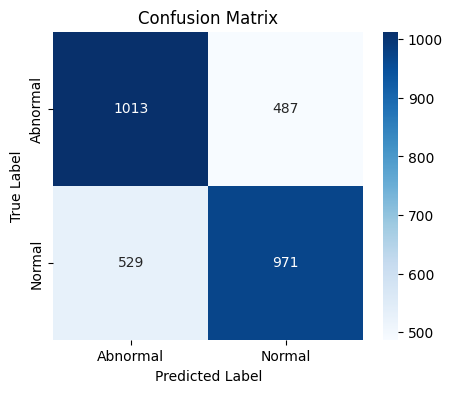

In [44]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Abnormal", "Normal"],
    yticklabels=["Abnormal", "Normal"]
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


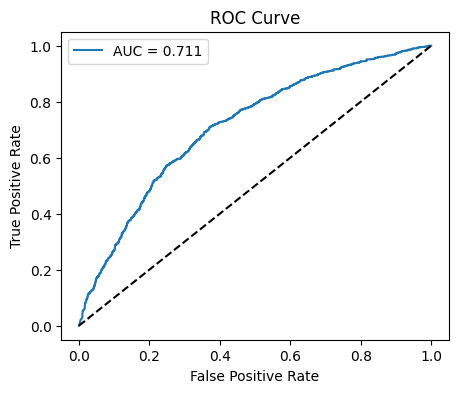

In [45]:
fpr, tpr, _ = roc_curve(y_true, y_prob)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [15]:
from torchvision import models
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = torch.nn.Linear(model.fc.in_features, 2)
model = model.to(device)

model.load_state_dict(torch.load(BEST_MODEL_PATH, weights_only=True))
model.eval()

print("✅ Model loaded")


✅ Model loaded


In [47]:
test_dataset = test_loader.dataset
class_names = test_dataset.classes

print("Classes:", class_names)


Classes: ['abnormal', 'normal']


<h1>GradCam</h1>
<p>Grad-CAM is used to visualize the spatial regions that contribute most to the model’s predictions.
This helps verify that the models focus on clinically relevant regions in chest X-ray images.</p>

In [16]:
import torch.nn.functional as F

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = output.argmax(dim=1)

        self.model.zero_grad()
        output[0, class_idx].backward()

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)

        cam = F.relu(cam)
        cam = cam - cam.min()
        cam = cam / cam.max()

        return cam.squeeze().cpu().numpy()


In [17]:
target_layer = model.layer4[-1]
gradcam = GradCAM(model, target_layer)

print("✅ Grad-CAM initialized")


✅ Grad-CAM initialized


In [95]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def show_gradcam(image, cam, label, pred):
    # Convert image tensor → numpy
    img = image.permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())

    # Normalize CAM
    cam = cam - cam.min()
    cam = cam / (cam.max() + 1e-8)

    # Resize CAM to image size
    cam_resized = cv2.resize(cam, (img.shape[1], img.shape[0]))

    # Apply color map
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = heatmap / 255.0

    # Overlay heatmap on image
    overlay = 0.6 * img + 0.4 * heatmap
    overlay = overlay / overlay.max()

    # Plot
    plt.figure(figsize=(9, 3))

    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(cam_resized, cmap="jet")
    plt.title("Grad-CAM")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.title(f"Overlay\nTrue:{label} Pred:{pred}")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


In [19]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def plot_gradcam_row(image, cam, true_label, pred_label, row_idx, fig):

    img = image.permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())

    cam = cv2.resize(cam, (img.shape[1], img.shape[0]))
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0

    overlay = 0.5 * img + 0.5 * heatmap

    ax1 = fig.add_subplot(3, 3, row_idx * 3 + 1)
    ax2 = fig.add_subplot(3, 3, row_idx * 3 + 2)
    ax3 = fig.add_subplot(3, 3, row_idx * 3 + 3)

    ax1.imshow(img, cmap="gray")
    ax1.set_title("Original")
    ax1.axis("off")

    ax2.imshow(cam, cmap="jet")
    ax2.set_title("Grad-CAM")
    ax2.axis("off")

    ax3.imshow(overlay)
    ax3.set_title(f"Overlay\nTrue:{true_label} Pred:{pred_label}")
    ax3.axis("off")


In [20]:
model.eval()
test_dataset = test_loader.dataset

samples = []

for idx in range(len(test_dataset)):
    image, label = test_dataset[idx]
    input_tensor = image.unsqueeze(0).to(device)


    output = model(input_tensor)
    pred = output.argmax(dim=1).item()


    cam = gradcam.generate(input_tensor)

    samples.append((image, cam, label, pred))

    
    if len(samples) == 3:
        break


C:\Users\aljaf\miniconda3\envs\torch\lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


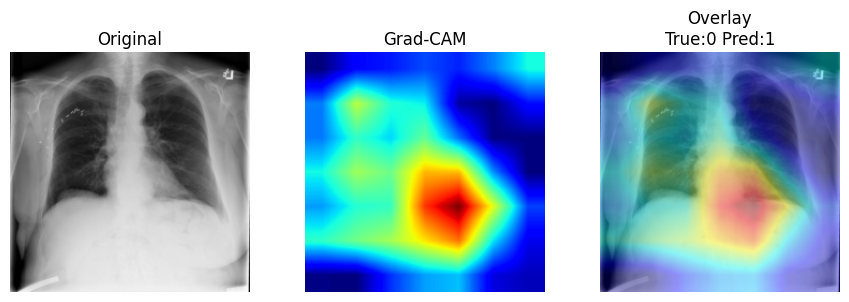

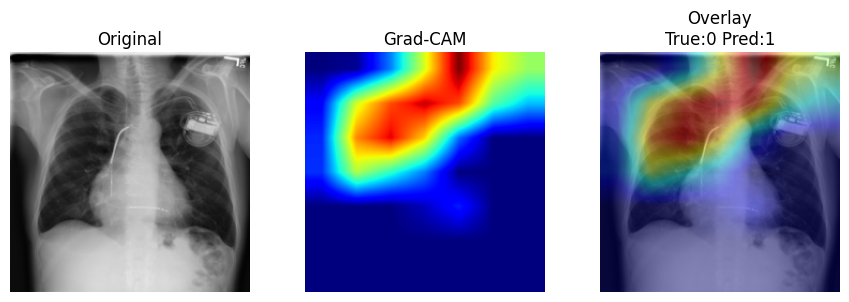

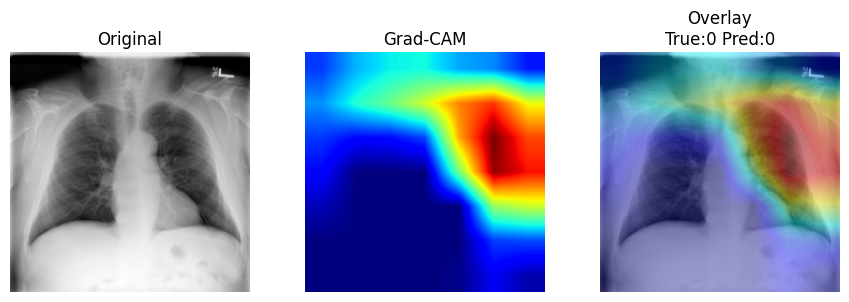

In [21]:
for image, cam, label, pred in samples:
    show_gradcam(image, cam, label, pred)


<h1>DenseNet-121</h1>

In [44]:
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)


model.classifier = nn.Linear(model.classifier.in_features, 2)

model = model.to(device)
model.eval()

print("✅ DenseNet-121 loaded")


✅ DenseNet-121 loaded


In [46]:
# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze last Dense block
for param in model.features.denseblock4.parameters():
    param.requires_grad = True

# Unfreeze classifier
for param in model.classifier.parameters():
    param.requires_grad = True


In [47]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4
)


In [81]:
EPOCHS = 20
patience = 5
counter = 0
best_val_acc = 0.0

BEST_MODEL_PATH = "best_densenet121.pth"

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(
        model,
        train_loader,
        optimizer,
        criterion,
    
    )

    val_acc = evaluate(model, val_loader)

    print(
        f"Epoch [{epoch+1}/{EPOCHS}] | "
        f"Train Loss: {train_loss:.4f} | "
        f"Train Acc: {train_acc:.4f} | "
        f"Val Acc: {val_acc:.4f}"
    )

    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        counter = 0
        torch.save(model.state_dict(), BEST_MODEL_PATH)
    else:
        counter += 1
        if counter >= patience:
            print("⛔ Early stopping triggered")
            break


Batch 0/438 - Loss: 0.7571
Batch 50/438 - Loss: 0.5601
Batch 100/438 - Loss: 0.6577
Batch 150/438 - Loss: 0.5589
Batch 200/438 - Loss: 0.6098
Batch 250/438 - Loss: 0.6371
Batch 300/438 - Loss: 0.6179
Batch 350/438 - Loss: 0.4967
Batch 400/438 - Loss: 0.7716
Epoch [1/20] | Train Loss: 0.6263 | Train Acc: 0.6564 | Val Acc: 0.6867
Batch 0/438 - Loss: 0.6768
Batch 50/438 - Loss: 0.5438
Batch 100/438 - Loss: 0.6010
Batch 150/438 - Loss: 0.5787
Batch 200/438 - Loss: 0.4743
Batch 250/438 - Loss: 0.5202
Batch 300/438 - Loss: 0.4923
Batch 350/438 - Loss: 0.4977
Batch 400/438 - Loss: 0.5270
Epoch [2/20] | Train Loss: 0.5651 | Train Acc: 0.7132 | Val Acc: 0.6850
Batch 0/438 - Loss: 0.5052
Batch 50/438 - Loss: 0.4289
Batch 100/438 - Loss: 0.4528
Batch 150/438 - Loss: 0.4380
Batch 200/438 - Loss: 0.5065
Batch 250/438 - Loss: 0.5681
Batch 300/438 - Loss: 0.3615
Batch 350/438 - Loss: 0.3769
Batch 400/438 - Loss: 0.3898
Epoch [3/20] | Train Loss: 0.5076 | Train Acc: 0.7519 | Val Acc: 0.6637
Batch 0/43

In [6]:
BEST_MODEL_PATH = "best_densenet121.pth"


In [10]:
from torchvision import models
import torch.nn as nn

model = models.densenet121(weights=None)
model.classifier = nn.Linear(model.classifier.in_features, 2)
model = model.to(device)

BEST_MODEL_PATH = "best_densenet121.pth"

model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))
model.eval()

print("✅ DenseNet-121 loaded correctly")


C:\Users\aljaf\AppData\Local\Temp\ipykernel_29716\258506048.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(BEST_MODEL_PATH, map_locati

✅ DenseNet-121 loaded correctly


In [11]:
model.load_state_dict(torch.load(BEST_MODEL_PATH, weights_only=True))
model.eval()
print("✅ Best DenseNet-121 model loaded")


✅ Best DenseNet-121 model loaded


In [12]:
for param in model.features.parameters():
    param.requires_grad = False


In [84]:
model.eval()

y_true = []
y_pred = []
y_prob = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1]  
        preds = outputs.argmax(dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_prob.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)


In [85]:
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_prob)

print("📊 Final Test Metrics")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")


📊 Final Test Metrics
Accuracy : 0.6770
Precision: 0.6812
Recall   : 0.6653
F1-score : 0.6732
AUC      : 0.7243


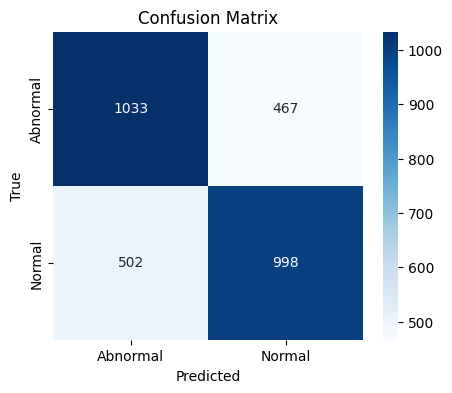

In [86]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Abnormal", "Normal"],
    yticklabels=["Abnormal", "Normal"]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


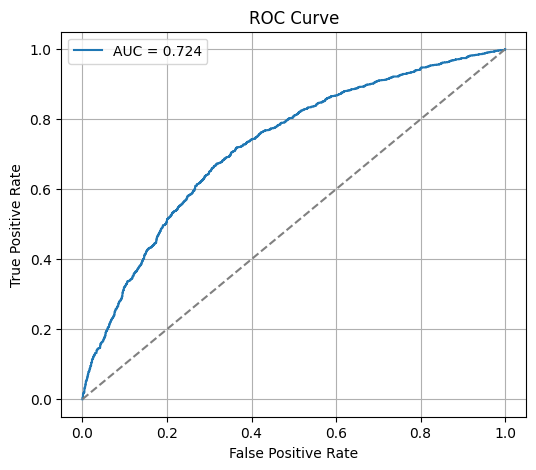

In [87]:
fpr, tpr, _ = roc_curve(y_true, y_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


In [34]:
target_layer = model.features.norm5
gradcam = GradCAM(model, target_layer)

print("✅ Grad-CAM ready for DenseNet-121")


✅ Grad-CAM ready for DenseNet-121


In [35]:
model.eval()
test_dataset = test_loader.dataset

samples = []
for idx in range(len(test_dataset)):
    image, label = test_dataset[idx]
    samples.append((image, label))
    if len(samples) == 3:
        break


In [37]:

for param in model.features.norm5.parameters():
    param.requires_grad = True


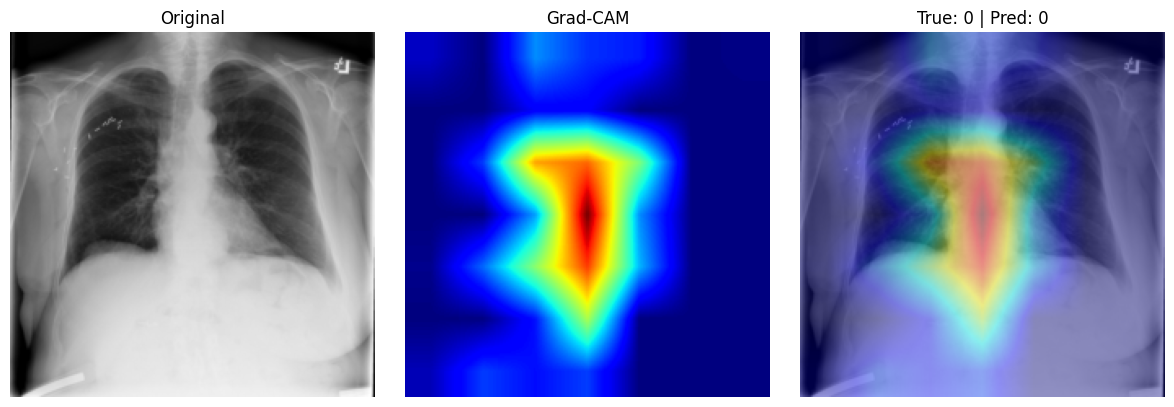

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000000238418578].


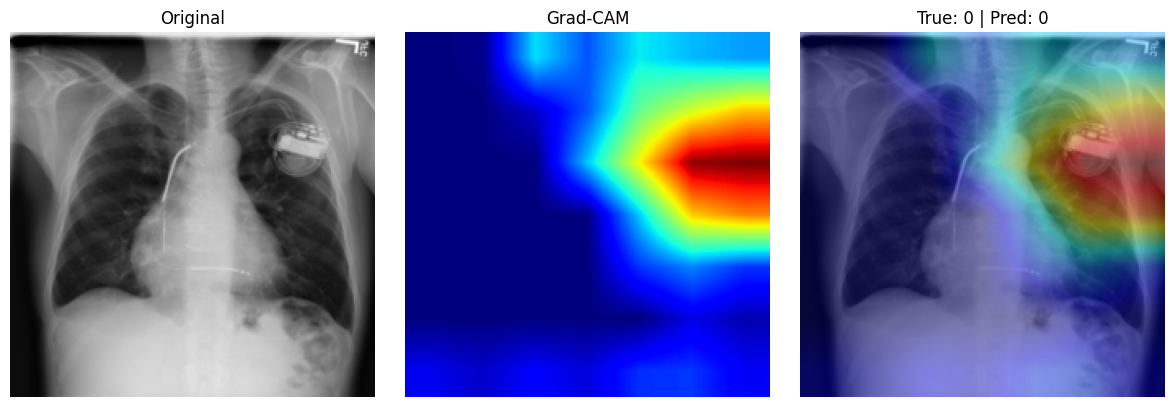

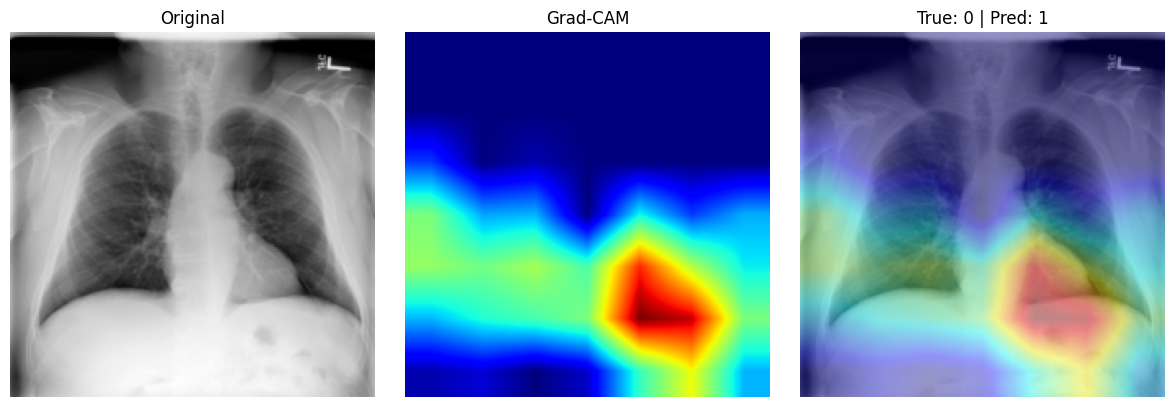

In [50]:
model.eval()

samples_shown = 0

for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    preds = outputs.argmax(dim=1)

    for i in range(images.size(0)):
        input_tensor = images[i].unsqueeze(0)

        cam = gradcam.generate(
            input_tensor,
            class_idx=preds[i].item()
        )

        visualize_gradcam_triplet(
            image=images[i],
            cam=cam,
            true_label=labels[i].item(),
            pred_label=preds[i].item()
        )

        samples_shown += 1
        if samples_shown == 3:
            break

    if samples_shown == 3:
        break


In [51]:
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [52]:
plt.savefig(f"gradcam_results/densenet_{i}.png", dpi=300)


<Figure size 640x480 with 0 Axes>

<h1>EfficientNet-B0</h1>

In [8]:
from torchvision import models
import torch.nn as nn
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.efficientnet_b0(
    weights=models.EfficientNet_B0_Weights.DEFAULT
)


model.classifier[1] = nn.Linear(
    model.classifier[1].in_features, 2
)

model = model.to(device)


In [9]:
for param in model.parameters():
    param.requires_grad = False


In [10]:
# Unfreeze last feature block
for param in model.features[-1].parameters():
    param.requires_grad = True

# Unfreeze classifier
for param in model.classifier.parameters():
    param.requires_grad = True


In [11]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4
)


In [13]:
EPOCHS = 20
patience = 5
counter = 0
best_val_acc = 0.0

BEST_MODEL_PATH = "best_efficientnet_b0.pth"

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(
        model,
        train_loader,
        optimizer,
        criterion,
        device
    )

    val_acc = evaluate(model, val_loader, device)

    print(
        f"Epoch [{epoch+1}/{EPOCHS}] | "
        f"Train Loss: {train_loss:.4f} | "
        f"Train Acc: {train_acc:.4f} | "
        f"Val Acc: {val_acc:.4f}"
    )

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        counter = 0
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print("✅ Best model saved")
    else:
        counter += 1
        if counter >= patience:
            print("⛔ Early stopping triggered")
            break


Batch 0/438 - Loss: 0.6917
Batch 50/438 - Loss: 0.6981
Batch 100/438 - Loss: 0.6330
Batch 150/438 - Loss: 0.6426
Batch 200/438 - Loss: 0.6512
Batch 250/438 - Loss: 0.7013
Batch 300/438 - Loss: 0.8040
Batch 350/438 - Loss: 0.8011
Batch 400/438 - Loss: 0.5152
Epoch [1/20] | Train Loss: 0.6453 | Train Acc: 0.6317 | Val Acc: 0.6707
✅ Best model saved
Batch 0/438 - Loss: 0.5464
Batch 50/438 - Loss: 0.7088
Batch 100/438 - Loss: 0.5445
Batch 150/438 - Loss: 0.5549
Batch 200/438 - Loss: 0.7218
Batch 250/438 - Loss: 0.5854
Batch 300/438 - Loss: 0.6997
Batch 350/438 - Loss: 0.5134
Batch 400/438 - Loss: 0.6747
Epoch [2/20] | Train Loss: 0.6233 | Train Acc: 0.6608 | Val Acc: 0.6700
Batch 0/438 - Loss: 0.6636
Batch 50/438 - Loss: 0.6777
Batch 100/438 - Loss: 0.6172
Batch 150/438 - Loss: 0.5700
Batch 200/438 - Loss: 0.5073
Batch 250/438 - Loss: 0.5652
Batch 300/438 - Loss: 0.5632
Batch 350/438 - Loss: 0.7467
Batch 400/438 - Loss: 0.6659
Epoch [3/20] | Train Loss: 0.6154 | Train Acc: 0.6688 | Val Acc

In [12]:
from torchvision import models
import torch.nn as nn

model = models.efficientnet_b0(weights=None)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)
model = model.to(device)


In [13]:
BEST_MODEL_PATH = "best_efficientnet_b0.pth"


In [14]:
model.load_state_dict(torch.load(BEST_MODEL_PATH, weights_only=True))
model.eval()

print("✅ Best EfficientNet-B0 model loaded")


✅ Best EfficientNet-B0 model loaded


In [7]:
import numpy as np
import torch
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve
)

y_true = []
y_pred = []
y_prob = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1] 
        preds = outputs.argmax(dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_prob.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)


In [17]:
acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec  = recall_score(y_true, y_pred)
f1   = f1_score(y_true, y_pred)
auc  = roc_auc_score(y_true, y_prob)

print("📊 EfficientNet-B0 Test Results")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")


📊 EfficientNet-B0 Test Results
Accuracy : 0.6767
Precision: 0.6642
Recall   : 0.7147
F1-score : 0.6885
AUC      : 0.7270


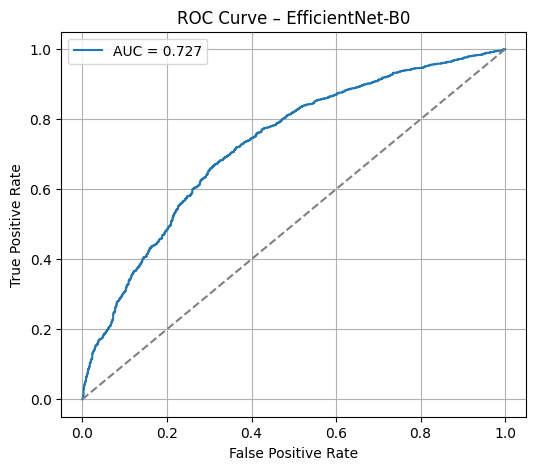

In [18]:
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_true, y_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – EfficientNet-B0")
plt.legend()
plt.grid(True)
plt.show()


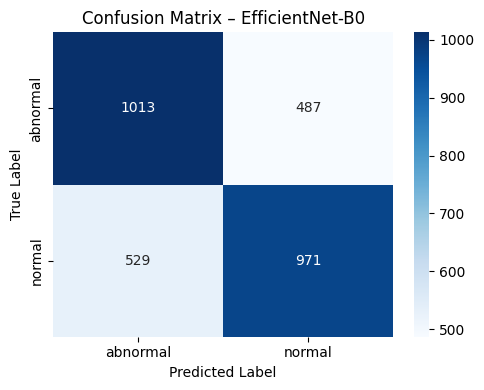

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


cm = confusion_matrix(y_true, y_pred)


class_names = ['abnormal', 'normal']


plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – EfficientNet-B0")
plt.tight_layout()
plt.show()


In [98]:
import torch
import torch.nn.functional as F

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output
            output.retain_grad()  

        self.target_layer.register_forward_hook(forward_hook)

    def generate(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        self.model.zero_grad()
        output[0, class_idx].backward()

        
        grads = self.activations.grad
        weights = grads.mean(dim=(2, 3), keepdim=True)

        cam = (weights * self.activations).sum(dim=1)
        cam = F.relu(cam)

        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)

        return cam.squeeze().detach().cpu().numpy()


In [99]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def visualize_gradcam_triplet(image, cam, true_label, pred_label):
    """
    image: Tensor (3,H,W)
    cam: Tensor or numpy array (H,W)
    """

    # ---- Image ----
    img = image.permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())

    
    if isinstance(cam, np.ndarray):
        cam_np = cam
    else:
        cam_np = cam.squeeze().cpu().numpy()

    cam_np = cv2.resize(cam_np, (img.shape[1], img.shape[0]))
    cam_np = (cam_np - cam_np.min()) / (cam_np.max() - cam_np.min())

    heatmap = cv2.applyColorMap(np.uint8(255 * cam_np), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0

    overlay = 0.6 * img + 0.4 * heatmap

    # ---- Plot ----
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(img)
    axes[0].set_title("Original")
    axes[0].axis("off")

    axes[1].imshow(cam_np, cmap="jet")
    axes[1].set_title("Grad-CAM")
    axes[1].axis("off")

    axes[2].imshow(overlay)
    axes[2].set_title(f"True: {true_label} | Pred: {pred_label}")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()


In [106]:
import numpy as np
import cv2

def show_gradcam_row(image, cam, true_label, pred_label):
    
    img = image.permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)

    
    if torch.is_tensor(cam):
        cam = cam.detach().cpu().numpy()

    cam = np.squeeze(cam)  
    cam = cv2.resize(cam, (img.shape[1], img.shape[0]))
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

    
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0

    overlay = 0.5 * img + 0.5 * heatmap
    overlay = np.clip(overlay, 0, 1)

    return img, cam, overlay


In [11]:
target_layer = model.features[-1]


In [101]:
model.eval()
class_names = test_loader.dataset.classes
samples_shown = 0

for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)

    input_tensor = images[0].unsqueeze(0)
    true_label = class_names[labels[0].item()]

    output = model(input_tensor)
    pred_idx = output.argmax(dim=1).item()
    pred_label = class_names[pred_idx]

    cam = gradcam.generate(input_tensor, class_idx=pred_idx)

    save_path = f"{SAVE_DIR}/sample_{samples_shown+1}_true_{true_label}_pred_{pred_label}.png"

    show_gradcam(
        image=images[0],
        cam=cam,
        label=true_label,
        pred=pred_label,
        save_path=save_path
    )

    print(f"Saved → {save_path}")

    samples_shown += 1
    if samples_shown == 3:
        break


Saved → gradcam_results/efficientnet_b0/sample_1_true_abnormal_pred_normal.png
Saved → gradcam_results/efficientnet_b0/sample_2_true_abnormal_pred_abnormal.png
Saved → gradcam_results/efficientnet_b0/sample_3_true_abnormal_pred_abnormal.png


In [102]:
import os
import matplotlib.pyplot as plt
from PIL import Image

SAVE_DIR = "gradcam_results/efficientnet_b0"



In [103]:
image_files = sorted([
    os.path.join(SAVE_DIR, f)
    for f in os.listdir(SAVE_DIR)
    if f.endswith(".png")
])


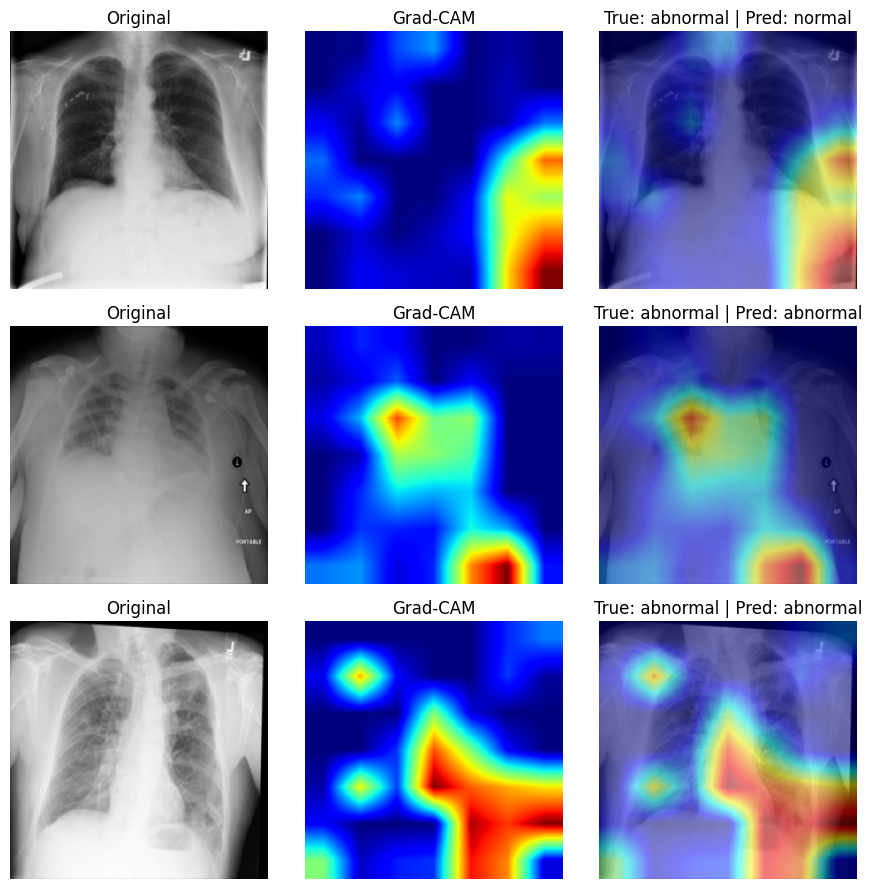

In [107]:
rows = 3
fig, axes = plt.subplots(rows, 3, figsize=(9, 9))

model.eval()
shown = 0

for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)

    input_tensor = images[0].unsqueeze(0)
    true_label = class_names[labels[0].item()]

    output = model(input_tensor)
    pred_idx = output.argmax(dim=1).item()
    pred_label = class_names[pred_idx]

    cam = gradcam.generate(input_tensor, class_idx=pred_idx)

    img, cam_map, overlay = show_gradcam_row(
        images[0], cam, true_label, pred_label
    )

    axes[shown, 0].imshow(img)
    axes[shown, 0].set_title("Original")
    axes[shown, 0].axis("off")

    axes[shown, 1].imshow(cam_map, cmap="jet")
    axes[shown, 1].set_title("Grad-CAM")
    axes[shown, 1].axis("off")

    axes[shown, 2].imshow(overlay)
    axes[shown, 2].set_title(f"True: {true_label} | Pred: {pred_label}")
    axes[shown, 2].axis("off")

    shown += 1
    if shown == rows:
        break

plt.tight_layout()
plt.show()


In [15]:
print("Model:", model.__class__.__name__)



Model: EfficientNet


In [16]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0))
print("Model device:", next(model.parameters()).device)


CUDA available: True
GPU name: NVIDIA GeForce RTX 4050 Laptop GPU
Model device: cuda:0


<h1>Grid Search</h1>

In [17]:


import os, time, json, math
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import models


def set_seed(seed=42):
    import random
    import numpy as np
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

# -----------------------
# 1) Grid definition (16 runs)
# -----------------------
final_grid = {
    "unfreeze_blocks": ["classifier_only", "last_block"],
    "learning_rate": [1e-3, 3e-4],
    "batch_size": [16, 32],
    "optimizer": ["Adam"],
    "dropout": [0.2, 0.3],
    "augmentation": ["basic"],  
}


GRID_DIR = "gridsearch_efficientnet_b0"
os.makedirs(GRID_DIR, exist_ok=True)


def build_efficientnet_b0(num_classes=2, dropout=0.2):
    
    weights = models.EfficientNet_B0_Weights.DEFAULT
    model = models.efficientnet_b0(weights=weights)
    in_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=dropout),
        nn.Linear(in_features, num_classes)
    )
    return model

def apply_unfreeze_strategy(model, strategy="classifier_only"):
    # Freeze all by default
    for p in model.parameters():
        p.requires_grad = False

    # Always train classifier
    for p in model.classifier.parameters():
        p.requires_grad = True

    if strategy == "last_block":
        # Unfreeze the LAST feature block (high-level features)
        for p in model.features[-1].parameters():
            p.requires_grad = True

    return model

@torch.no_grad()
def evaluate_acc(model, loader, device):
    model.eval()
    correct, total = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.numel()
    return correct / max(1, total)

def train_one_epoch(model, loader, optimizer, criterion, device, print_batches=False):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for b, (x, y) in enumerate(loader):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.numel()

        if print_batches and (b % 50 == 0 or b == len(loader)-1):
            print(f"  Batch {b}/{len(loader)} | Loss: {loss.item():.4f}")

    epoch_loss = running_loss / max(1, total)
    epoch_acc = correct / max(1, total)
    return epoch_loss, epoch_acc


def make_loaders(batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    return train_loader, val_loader


EPOCHS = 15
patience = 4  
criterion = nn.CrossEntropyLoss()

results = []  
run_id = 0

def iter_grid(grid):

    from itertools import product
    keys = list(grid.keys())
    values = [grid[k] for k in keys]
    for combo in product(*values):
        yield dict(zip(keys, combo))

for cfg in iter_grid(final_grid):
    run_id += 1
    print("\n" + "="*70)
    print(f"Run {run_id} / 16 | {cfg}")
    print("="*70)

    
    train_loader, val_loader = make_loaders(cfg["batch_size"])

    
    model = build_efficientnet_b0(num_classes=2, dropout=cfg["dropout"])
    model = apply_unfreeze_strategy(model, cfg["unfreeze_blocks"])
    model = model.to(device)

    
    if cfg["optimizer"] == "Adam":
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                                     lr=cfg["learning_rate"], weight_decay=1e-4)
    else:
        raise ValueError("Only Adam included in this grid for safety.")

    
    best_val_acc = -1.0
    best_path = os.path.join(GRID_DIR, f"best_run_{run_id}.pth")
    bad_epochs = 0

    start_time = time.time()

    for epoch in range(EPOCHS):
    
        train_loss, train_acc = train_one_epoch(
            model, train_loader, optimizer, criterion, device,
            print_batches=True
        )

        val_acc = evaluate_acc(model, val_loader, device)

        print(f"Epoch [{epoch+1:02d}/{EPOCHS}] | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

        
        if val_acc > best_val_acc + 1e-6:
            best_val_acc = val_acc
            bad_epochs = 0
            torch.save(model.state_dict(), best_path)
        else:
            bad_epochs += 1
            if bad_epochs >= patience:
                print("⛔ Early stopping triggered")
                break

    elapsed = time.time() - start_time

    
    run_result = {
        "run_id": run_id,
        "config": cfg,
        "best_val_acc": float(best_val_acc),
        "best_model_path": best_path,
        "elapsed_minutes": float(elapsed / 60.0)
    }
    results.append(run_result)

    
    with open(os.path.join(GRID_DIR, "grid_results.json"), "w") as f:
        json.dump(results, f, indent=2)

    print(f"✅ Run {run_id} finished | Best Val Acc: {best_val_acc:.4f} | Time: {elapsed/60:.1f} min")
    print(f"   Saved: {best_path}")


results_sorted = sorted(results, key=lambda r: r["best_val_acc"], reverse=True)
print("\nTop 5 configurations:")
for r in results_sorted[:5]:
    print(f"- Run {r['run_id']} | Val Acc: {r['best_val_acc']:.4f} | "
          f"cfg={r['config']} | time={r['elapsed_minutes']:.1f}min")

best_overall = results_sorted[0]
print("\n🏆 Best overall:")
print(best_overall)


with open(os.path.join(GRID_DIR, "best_run.json"), "w") as f:
    json.dump(best_overall, f, indent=2)



Run 1 / 16 | {'unfreeze_blocks': 'classifier_only', 'learning_rate': 0.001, 'batch_size': 16, 'optimizer': 'Adam', 'dropout': 0.2, 'augmentation': 'basic'}
  Batch 0/875 | Loss: 0.7147
  Batch 50/875 | Loss: 0.7155
  Batch 100/875 | Loss: 0.6508
  Batch 150/875 | Loss: 0.8114
  Batch 200/875 | Loss: 0.6753
  Batch 250/875 | Loss: 0.7731
  Batch 300/875 | Loss: 0.7490
  Batch 350/875 | Loss: 0.7876
  Batch 400/875 | Loss: 0.7563
  Batch 450/875 | Loss: 0.5782
  Batch 500/875 | Loss: 0.8221
  Batch 550/875 | Loss: 0.6699
  Batch 600/875 | Loss: 0.6145
  Batch 650/875 | Loss: 0.6603
  Batch 700/875 | Loss: 0.6108
  Batch 750/875 | Loss: 0.6676
  Batch 800/875 | Loss: 0.7969
  Batch 850/875 | Loss: 0.4959
  Batch 874/875 | Loss: 0.6484
Epoch [01/15] | Train Loss: 0.6574 | Train Acc: 0.6259 | Val Acc: 0.6630
  Batch 0/875 | Loss: 0.6826
  Batch 50/875 | Loss: 0.6270
  Batch 100/875 | Loss: 0.7536
  Batch 150/875 | Loss: 0.5092
  Batch 200/875 | Loss: 0.8231
  Batch 250/875 | Loss: 0.4843
 

In [43]:
from torchvision import models
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Build model EXACTLY like grid search
weights = models.EfficientNet_B0_Weights.DEFAULT
model = models.efficientnet_b0(weights=weights)

# Replace classifier EXACTLY
in_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=0.3),   # ← MUST match best grid run (run 16)
    nn.Linear(in_features, 2)
)

model = model.to(device)


In [44]:
state_dict = torch.load(
    "gridsearch_efficientnet_b0/best_run_16.pth",
    map_location=device
)

model.load_state_dict(state_dict)
model.eval()

print("✅ Grid-search EfficientNet-B0 loaded successfully")


C:\Users\aljaf\AppData\Local\Temp\ipykernel_28400\2888812427.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(


✅ Grid-search EfficientNet-B0 loaded successfully


In [45]:
print("Model:", model.__class__.__name__)
print(model.classifier)


Model: EfficientNet
Sequential(
  (0): Dropout(p=0.3, inplace=False)
  (1): Linear(in_features=1280, out_features=2, bias=True)
)


In [47]:
import torch
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)

model.eval()

y_true = []
y_pred = []
y_prob = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # probability of class "abnormal"
        preds = outputs.argmax(dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_prob.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)


In [48]:
acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec  = recall_score(y_true, y_pred)
f1   = f1_score(y_true, y_pred)
auc  = roc_auc_score(y_true, y_prob)

print("📊 EfficientNet-B0 (Grid Search) — Test Metrics")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")


📊 EfficientNet-B0 (Grid Search) — Test Metrics
Accuracy : 0.6737
Precision: 0.6563
Recall   : 0.7293
F1-score : 0.6909
AUC      : 0.7265


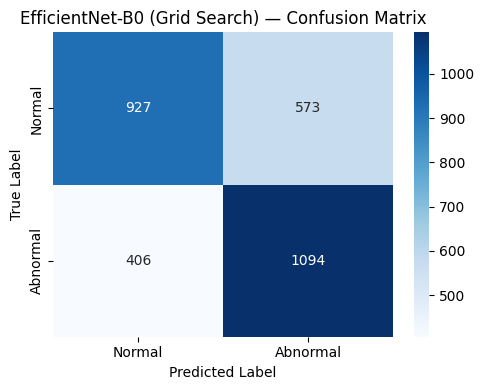

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

class_names = ["Normal", "Abnormal"]

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("EfficientNet-B0 (Grid Search) — Confusion Matrix")
plt.tight_layout()
plt.show()


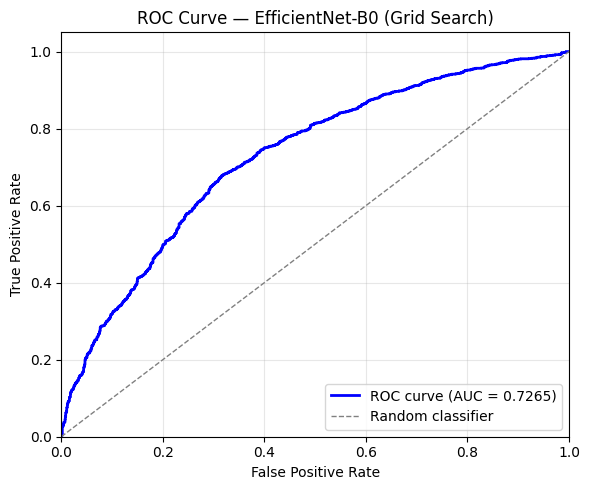

In [50]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color="blue", linewidth=2,
         label=f"ROC curve (AUC = {roc_auc:.4f})")

plt.plot([0, 1], [0, 1], color="gray", linestyle="--", linewidth=1,
         label="Random classifier")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — EfficientNet-B0 (Grid Search)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


<h1>Creating an imbalance scenario</h1>

In [28]:
print("Train exists:", os.path.exists(ORIGINAL_TRAIN_DIR))
print("Normal exists:", os.path.exists(os.path.join(ORIGINAL_TRAIN_DIR, "normal")))
print("Abnormal exists:", os.path.exists(os.path.join(ORIGINAL_TRAIN_DIR, "abnormal")))


Train exists: False
Normal exists: False
Abnormal exists: False


In [29]:
import os
import shutil
import random

DATASET_ROOT = r"C:\Users\aljaf\Downloads\chestxray_20k"

ORIGINAL_TRAIN_DIR = os.path.join(DATASET_ROOT, "train")
IMBALANCED_TRAIN_DIR = os.path.join(DATASET_ROOT, "train_imbalanced_80_20")

CLASS_RATIOS = {
    "normal": 1.0,      # keep 100% normal
    "abnormal": 0.2     # keep 20% abnormal
}

os.makedirs(IMBALANCED_TRAIN_DIR, exist_ok=True)

for cls, ratio in CLASS_RATIOS.items():
    src_dir = os.path.join(ORIGINAL_TRAIN_DIR, cls)
    dst_dir = os.path.join(IMBALANCED_TRAIN_DIR, cls)
    os.makedirs(dst_dir, exist_ok=True)

    images = os.listdir(src_dir)
    random.shuffle(images)

    keep_n = int(len(images) * ratio)
    selected = images[:keep_n]

    for img in selected:
        shutil.copy(
            os.path.join(src_dir, img),
            os.path.join(dst_dir, img)
        )

    print(f"{cls}: kept {keep_n}/{len(images)} images")

print("✅ 80/20 imbalanced training set created successfully")


normal: kept 7000/7000 images
abnormal: kept 1400/7000 images
✅ 80/20 imbalanced training set created successfully


In [31]:
from torchvision import datasets
from torch.utils.data import DataLoader

IMBALANCED_TRAIN_DIR = r"C:\Users\aljaf\Downloads\chestxray_20k\train_imbalanced_80_20"

train_dataset = datasets.ImageFolder(
    root=IMBALANCED_TRAIN_DIR,
    transform=train_transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

print("Classes:", train_dataset.classes)
print("Training samples:", len(train_dataset))


Classes: ['abnormal', 'normal']
Training samples: 8400


In [36]:
print("Model class:", model.__class__.__name__)


Model class: EfficientNet


In [41]:
import time
import torch
NUM_EPOCHS = 15
PRINT_EVERY = 50

best_val_acc = 0.0
start_time = time.time()

early_stopping = EarlyStopping(patience=3)

for epoch in range(NUM_EPOCHS):

  
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        if batch_idx % PRINT_EVERY == 0 or batch_idx == len(train_loader) - 1:
            print(f"Batch {batch_idx}/{len(train_loader)-1} | Loss: {loss.item():.4f}")

    train_loss = running_loss / total
    train_acc = correct / total


    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total

  
    print(
        f"Epoch [{epoch+1:02d}/{NUM_EPOCHS}] | "
        f"Train Loss: {train_loss:.4f} | "
        f"Train Acc: {train_acc:.4f} | "
        f"Val Acc: {val_acc:.4f}"
    )

 
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), SAVE_PATH)


    early_stopping(val_acc)
    if early_stopping.early_stop:
        print("🛑 Early stopping triggered")
        break


elapsed = (time.time() - start_time) / 60
print(f"✅ Run finished | Best Val Acc: {best_val_acc:.4f} | Time: {elapsed:.1f} min")
print(f"Saved: {SAVE_PATH}")


Batch 0/262 | Loss: 0.4972
Batch 50/262 | Loss: 0.3695
Batch 100/262 | Loss: 0.3117
Batch 150/262 | Loss: 0.4524
Batch 200/262 | Loss: 0.3686
Batch 250/262 | Loss: 0.3765
Batch 262/262 | Loss: 0.2422
Epoch [01/15] | Train Loss: 0.3693 | Train Acc: 0.8485 | Val Acc: 0.5467
Batch 0/262 | Loss: 0.2293
Batch 50/262 | Loss: 0.4359
Batch 100/262 | Loss: 0.2516
Batch 150/262 | Loss: 0.3488
Batch 200/262 | Loss: 0.4924
Batch 250/262 | Loss: 0.1924
Batch 262/262 | Loss: 0.4027
Epoch [02/15] | Train Loss: 0.3572 | Train Acc: 0.8489 | Val Acc: 0.5307
Batch 0/262 | Loss: 0.3792
Batch 50/262 | Loss: 0.1609
Batch 100/262 | Loss: 0.6041
Batch 150/262 | Loss: 0.3799
Batch 200/262 | Loss: 0.3058
Batch 250/262 | Loss: 0.3026
Batch 262/262 | Loss: 0.2580
Epoch [03/15] | Train Loss: 0.3518 | Train Acc: 0.8521 | Val Acc: 0.5197
Batch 0/262 | Loss: 0.2056
Batch 50/262 | Loss: 0.2446
Batch 100/262 | Loss: 0.2572
Batch 150/262 | Loss: 0.2000
Batch 200/262 | Loss: 0.1633
Batch 250/262 | Loss: 0.4517
Batch 262/

In [1]:
# Standard MLOps practice: Save state_dict, not the whole model
torch.save(model.state_dict(), "chest_xray_model.pth")

NameError: name 'torch' is not defined